In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import urllib
import numpy as np
import zipfile
import os
from scipy.misc import imsave


In [3]:
def imcrop_tosquare(img):
    """Make any image a square image.
    Parameters
    ----------
    img : np.ndarray
        Input image to crop, assumed at least 2d.
    Returns
    -------
    crop : np.ndarray
        Cropped image.
    """
    size = np.min(img.shape[:2])
    extra = img.shape[:2] - size
    crop = img
    for i in np.flatnonzero(extra):
        crop = np.take(crop, extra[i] // 2 + np.r_[:size], axis=i)
    return crop


def montage(images, saveto='montage.png'):
    """Draw all images as a montage separated by one pixel borders.
    Also saves the file to the destination specified by `saveto`.
    Parameters
    ----------
    images : numpy.ndarray
        Input array to create montage of.  Array should be:
        batch x height x width x channels.
    saveto : str
        Location to save the resulting montage image.
    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    elif len(images.shape) == 4 and images.shape[3] == 1:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1)) * 0.5
    elif len(images.shape) == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(
            images.shape))
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    imsave(arr=np.squeeze(m), name=saveto)
    return m


def get_celeb_files():
    """Downloads the first 100 images of the celeb dataset.
    Files will be placed in a directory 'img_align_celeba' if one
    doesn't exist.
    Returns
    -------
    files : list of strings
        Locations to the first 100 images of the celeb net dataset.
    """
    # Create a directory
    if not os.path.exists('img_align_celeba'):
        os.mkdir('img_align_celeba')

    # Now perform the following 100 times:
    for img_i in range(1, 101):

        # create a string using the current loop counter
        f = '000%03d.jpg' % img_i

        if os.path.exists('img_align_celeba/'+f):
            continue

        # and get the url with that string appended the end
        url = 'https://s3.amazonaws.com/cadl/celeb-align/' + f

        # We'll print this out to the console so we can see how far we've gone
        print(url, end='\r')

        # And now download the url to a location inside our new directory
        urllib.request.urlretrieve(url, os.path.join('img_align_celeba', f))

    files = [os.path.join('img_align_celeba', file_i)
             for file_i in os.listdir('img_align_celeba')
             if '.jpg' in file_i]
    return files


def get_celeb_imgs():
    """Loads the first 100 images of the celeb dataset.
    Returns
    -------
    imgs : list of np.ndarray
        List of the first 100 images from the celeb dataset
    """
    return [plt.imread(f_i) for f_i in get_celeb_files()]


def gauss(mean, stddev, ksize):
    """Uses Tensorflow to compute a Gaussian Kernel.
    Parameters
    ----------
    mean : float
        Mean of the Gaussian (e.g. 0.0).
    stddev : float
        Standard Deviation of the Gaussian (e.g. 1.0).
    ksize : int
        Size of kernel (e.g. 16).
    Returns
    -------
    kernel : np.ndarray
        Computed Gaussian Kernel using Tensorflow.
    """
    g = tf.Graph()
    with tf.Session(graph=g):
        x = tf.linspace(-3.0, 3.0, ksize)
        z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                           (2.0 * tf.pow(stddev, 2.0)))) *
             (1.0 / (stddev * tf.sqrt(2.0 * 3.1415))))
        return z.eval()


def gauss2d(mean, stddev, ksize):
    """Uses Tensorflow to compute a 2D Gaussian Kernel.
    Parameters
    ----------
    mean : float
        Mean of the Gaussian (e.g. 0.0).
    stddev : float
        Standard Deviation of the Gaussian (e.g. 1.0).
    ksize : int
        Size of kernel (e.g. 16).
    Returns
    -------
    kernel : np.ndarray
        Computed 2D Gaussian Kernel using Tensorflow.
    """
    z = gauss(mean, stddev, ksize)
    g = tf.Graph()
    with tf.Session(graph=g):
        z_2d = tf.matmul(tf.reshape(z, [ksize, 1]), tf.reshape(z, [1, ksize]))
        return z_2d.eval()


def convolve(img, kernel):
    """Uses Tensorflow to convolve a 4D image with a 4D kernel.
    Parameters
    ----------
    img : np.ndarray
        4-dimensional image shaped N x H x W x C
    kernel : np.ndarray
        4-dimensional image shape K_H, K_W, C_I, C_O corresponding to the
        kernel's height and width, the number of input channels, and the
        number of output channels.  Note that C_I should = C.
    Returns
    -------
    result : np.ndarray
        Convolved result.
    """
    g = tf.Graph()
    with tf.Session(graph=g):
        convolved = tf.nn.conv2d(img, kernel, strides=[1, 1, 1, 1], padding='SAME')
        res = convolved.eval()
    return res


def gabor(ksize=32):
    """Uses Tensorflow to compute a 2D Gabor Kernel.
    Parameters
    ----------
    ksize : int, optional
        Size of kernel.
    Returns
    -------
    gabor : np.ndarray
        Gabor kernel with ksize x ksize dimensions.
    """
    g = tf.Graph()
    with tf.Session(graph=g):
        z_2d = gauss2d(0.0, 1.0, ksize)
        ones = tf.ones((1, ksize))
        ys = tf.sin(tf.linspace(-3.0, 3.0, ksize))
        ys = tf.reshape(ys, [ksize, 1])
        wave = tf.matmul(ys, ones)
        gabor = tf.multiply(wave, z_2d)
        return gabor.eval()


def build_submission(filename, file_list):
    """Helper utility to check homework assignment submissions and package them.
    Parameters
    ----------
    filename : str
        Output zip file name
    file_list : tuple
        Tuple of files to include
    """
    # check each file exists
    for part_i, file_i in enumerate(file_list):
        assert os.path.exists(file_i), \
            '\nYou are missing the file {}.  '.format(file_i) + \
            'It does not look like you have completed Part {}.'.format(
                part_i + 1)

    # great, each file exists
    print('It looks like you have completed each part!')

    def zipdir(path, zf):
        for root, dirs, files in os.walk(path):
            for file in files:
                # make sure the files are part of the necessary file list
                if file.endswith(file_list):
                    zf.write(os.path.join(root, file))

    # create a zip file with the necessary files
    zipf = zipfile.ZipFile(filename, 'w', zipfile.ZIP_DEFLATED)
    zipdir('.', zipf)
    zipf.close()
    print('Great job!!!')
    print('Now submit the file:\n{}\nto Kadenze for grading!'.format(
os.path.abspath(filename)))

In [4]:
files = get_celeb_files()


In [5]:
img = plt.imread(files[50])
# img.<tab>
print(img)

[[[ 35  33  36]
  [ 35  33  36]
  [ 35  33  36]
  ..., 
  [202 193 188]
  [202 193 188]
  [202 193 188]]

 [[ 35  33  36]
  [ 35  33  36]
  [ 35  33  36]
  ..., 
  [202 193 188]
  [202 193 188]
  [202 193 188]]

 [[ 35  33  36]
  [ 35  33  36]
  [ 35  33  36]
  ..., 
  [202 193 188]
  [202 193 188]
  [202 193 188]]

 ..., 
 [[ 39  37  40]
  [ 39  37  40]
  [ 39  37  40]
  ..., 
  [209 179 153]
  [219 189 161]
  [219 189 161]]

 [[ 39  37  40]
  [ 39  37  40]
  [ 39  37  40]
  ..., 
  [218 188 162]
  [223 193 165]
  [223 193 165]]

 [[ 39  37  40]
  [ 39  37  40]
  [ 39  37  40]
  ..., 
  [218 188 162]
  [223 193 165]
  [223 193 165]]]


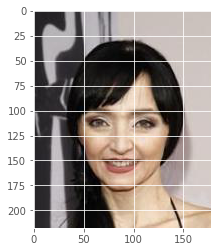

In [6]:
plt.imshow(img)

In [7]:
img.shape
#rows,col,color channels

(218, 178, 3)

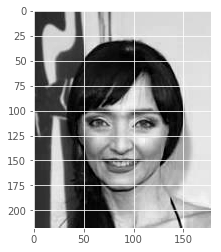

In [8]:
plt.imshow(img[:, :, 0], cmap='gray')
plt.imshow(img[:, :, 1], cmap='gray')
plt.imshow(img[:, :, 2], cmap='gray')
#looking at one of the color channels

In [10]:
imgs = get_celeb_imgs()

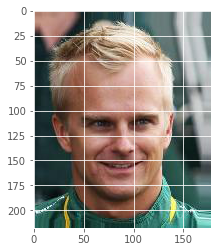

In [11]:
plt.imshow(imgs[0])
#NHWC

In [12]:
imgs[0].shape

(218, 178, 3)

In [13]:
#combine all images to have 4 dimensions
data = np.array(imgs)
data.shape

(100, 218, 178, 3)

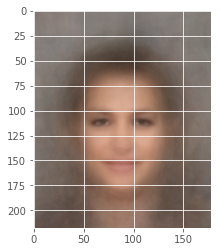

In [14]:
#taking mean of the batch channel:
mean_img = np.mean(data, axis=0)
plt.imshow(mean_img.astype(np.uint8))
# describes what most of our dataset looks like

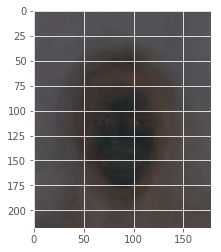

In [15]:
std_img = np.std(data, axis=0)
plt.imshow(std_img.astype(np.uint8))
# how much variance there is in previous mean image representation

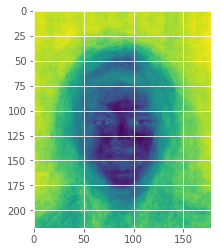

In [17]:
plt.imshow(np.mean(std_img, axis=2).astype(np.uint8))
#variance for each color channel represented separately, and then combined as a color image.
#average variance over all color channels by taking their mean:

 The more red, the more likely that our mean image is not the best representation. The more blue, the less likely that our mean image is far off from any other possible image.

 "preprocessing" : removing the mean and standard deviation.
                   Subtracting the mean, and dividing by the standard deviation. 
                   Another word for that is "normalization".

In [18]:
#NHWC array converted to one dimensional array

flattened = data.ravel()
print(data[:1])
print(flattened[:10])

# Instead of having 4 dimensions, only 1 dimension of every pixel value stretched out in a long vector, or 1 dimensional array.


[[[[173 126 110]
   [173 126 110]
   [173 126 110]
   ..., 
   [103 129 130]
   [104 124 123]
   [104 124 123]]

  [[173 126 110]
   [173 126 110]
   [173 126 110]
   ..., 
   [102 128 129]
   [104 124 123]
   [104 124 123]]

  [[173 126 110]
   [173 126 110]
   [173 126 110]
   ..., 
   [102 128 129]
   [104 124 123]
   [104 124 123]]

  ..., 
  [[ 42 103  98]
   [ 42 103  98]
   [ 38  99  92]
   ..., 
   [109 205 191]
   [110 202 187]
   [110 202 187]]

  [[ 42 103  98]
   [ 44 105 100]
   [ 38  99  92]
   ..., 
   [ 90 183 172]
   [ 96 187 172]
   [ 96 187 172]]

  [[ 42 103  98]
   [ 44 105 100]
   [ 38  99  92]
   ..., 
   [ 92 182 172]
   [ 97 183 170]
   [ 97 183 170]]]]
[173 126 110 173 126 110 173 126 110 173]


(array([ 216804.,  117821.,   99125.,   71049.,   66478.,   62066.,
          62528.,   58085.,   56686.,   56114.,   56848.,   58551.,
          63168.,   61086.,   59193.,   59305.,   62526.,   63596.,
          62285.,   65061.,   63389.,   61989.,   61411.,   60742.,
          60464.,   60307.,   59074.,   59312.,   60353.,   64807.,
          67305.,   61667.,   59906.,   60546.,   62017.,   62268.,
          63030.,   62799.,   62396.,   62609.,   59541.,   58918.,
          57822.,   61451.,   63481.,   57782.,   57212.,   56516.,
          56039.,   58385.,   56252.,   55089.,   54677.,   52066.,
          51012.,   48826.,   47602.,   46064.,   45351.,   43735.,
          42849.,   42903.,   42571.,   41789.,   42412.,   42705.,
          42982.,   43107.,   43372.,   43416.,   43323.,   42808.,
          42253.,   42302.,   42008.,   41846.,   42800.,   42476.,
          42435.,   42405.,   42584.,   42612.,   42671.,   42344.,
          42610.,   42023.,   42214.,   41700., 

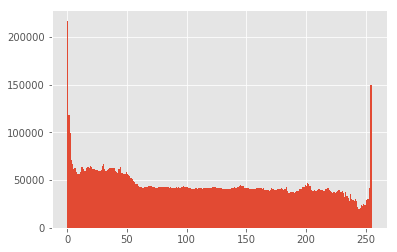

In [19]:
plt.hist(flattened.ravel(), 255)

histogram of every value in the vector - use 255 bins.
Each bin - grouping a range of values, describe the frequency or how many times anything       within that range of values appears.

# HISTOGRAM EQUALIZATION
mean of dataset

(array([    2.,     0.,     0.,     0.,     2.,    18.,    30.,    23.,
           42.,    42.,    43.,    41.,    51.,    48.,    30.,    52.,
           58.,    59.,    67.,    67.,    71.,    83.,    94.,   110.,
          110.,   107.,   134.,   103.,   109.,   160.,   198.,   206.,
          211.,   265.,   306.,   289.,   344.,   335.,   361.,   382.,
          402.,   390.,   400.,   497.,   544.,   594.,   663.,   679.,
          749.,   803.,   847.,   882.,   886.,   938.,   817.,   857.,
          801.,   825.,   831.,   896.,   875.,   861.,   843.,   870.,
          842.,   897.,   863.,   861.,   906.,   939.,   905.,   935.,
          946.,   972.,  1004.,  1064.,  1079.,  1124.,  1162.,  1103.,
         1129.,  1108.,  1085.,  1079.,  1051.,  1155.,  1068.,  1093.,
         1170.,  1171.,  1146.,  1213.,  1146.,  1174.,  1211.,  1229.,
         1173.,  1196.,  1216.,  1150.,  1255.,  1373.,  1344.,  1445.,
         1554.,  1554.,  1553.,  1478.,  1506.,  1469.,  1546., 

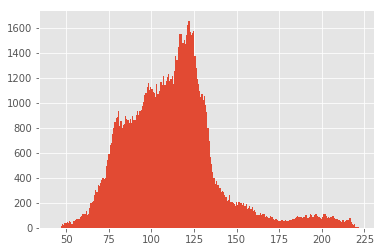

In [20]:
plt.hist(mean_img.ravel(), 255)

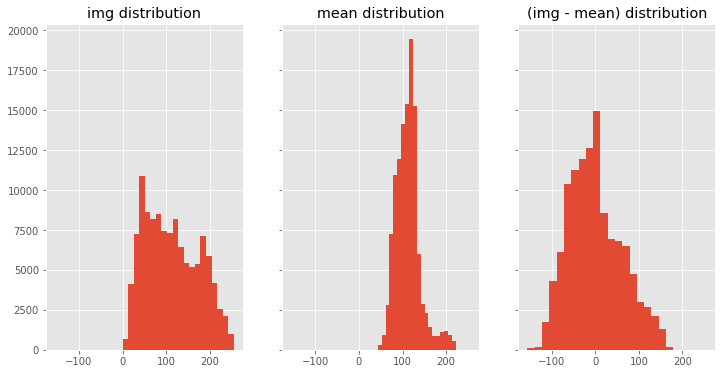

In [21]:
#compare before and after normalizing data
bins = 20
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist((data[0]).ravel(), bins)
axs[0].set_title('img distribution')
axs[1].hist((mean_img).ravel(), bins)
axs[1].set_title('mean distribution')
axs[2].hist((data[0] - mean_img).ravel(), bins)
axs[2].set_title('(img - mean) distribution')

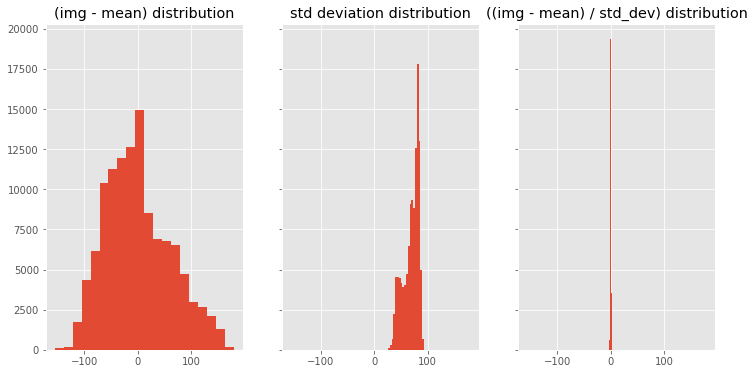

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist((data[0] - mean_img).ravel(), bins)
axs[0].set_title('(img - mean) distribution')
axs[1].hist((std_img).ravel(), bins)
axs[1].set_title('std deviation distribution')
axs[2].hist(((data[0] - mean_img) / std_img).ravel(), bins)
axs[2].set_title('((img - mean) / std_dev) distribution')

In [23]:
axs[2].set_xlim([-150, 150])
axs[2].set_xlim([-100, 100])
axs[2].set_xlim([-50, 50])
axs[2].set_xlim([-10, 10])
axs[2].set_xlim([-5, 5])

(-5, 5)

If our data does not end up looking like this, then we should either (1): get much more data to calculate our mean/std deviation, or (2): either try another method of normalization, such as scaling the values between 0 to 1, or -1 to 1, or possibly not bother with normalization at all. other options including different types of normalization such as local contrast normalization for images or PCA based normalization.